In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import time
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.lines import Line2D
import scipy.stats as stats 
import matplotlib.ticker as mticker
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

In [2]:
df_bot_accounts = pd.read_csv('data/bots.csv')
df= pd.read_csv('data/tweets.csv')
df.created_at = pd.to_datetime(df['created_at'])
df = df.loc[~df.ID.isin(list(df_bot_accounts.ID))]

# Keep 0 VADER - SI Method 1

In [3]:
df_main = df.loc[df.created_at < '2020-03-01']
print('Before March 2020 n =',df_main.vader.count())

all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']
x = [np.log10(n) for n in [2,3,4,5,7,10,14,21,28,42,60,90,120,150,180,365,730,3*365,4*365,5*365,10*365,20*365,30*365]] 
all_tweets = [df_main.loc[df_main['phrase'] == phrase]["vader"].mean() for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef)
r = stats.pearsonr(x,all_tweets)
print(r)
print(r[0]**2)

Before March 2020 n = 2565735
(-0.6342723567247854, 0.0011525977260104258)
0.40230142250521345


In [4]:
all_months = ["2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01",
             "2018-01-01","2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01",
             "2018-07-01","2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01",
             "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
             "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
             "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
             "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01"]

df_main = df.copy()
df_main.created_at = pd.to_datetime(df_main['created_at'])

# Get a list of the mean for each phrase for each month
all_phrases_2 = []
months = []
all_means = []

for i in range(len(all_months)-1):        
    # Get the appropriate month

    # Select only tweets in these dates
    mask = (pd.Timestamp(all_months[i]+' 00:00:00+0000') <= df_main['created_at']) & (df_main['created_at'] < pd.Timestamp(all_months[i + 1]+' 00:00:00+0000'))
    df_t = df_main.loc[mask]

    for phrase in all_phrases:
        months.append(all_months[i])
        all_phrases_2.append(phrase)
        all_means.append(df_t.loc[df_t['phrase'] == phrase].vader.mean())

df_stats = pd.DataFrame({'date':months,'phrase':all_phrases_2, 'mean':all_means})

all_curves = []
all_means = []
mse = []
cors, ps = [], []

for i in range(len(all_months)-1):
    t_1 = all_months[i]
    t_2 = all_months[i+1]

    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_main['created_at']) & (df_main['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_t = df_main.loc[mask]
    all_means.append(df_t["vader"].mean())

    all_tweets = [df_t.loc[df_t['phrase'] == phrase]["vader"].mean() for phrase in all_phrases]
    coef = np.polyfit(x,all_tweets,1)
    all_curves.append(coef[0])
    poly1d_fn = np.poly1d(coef) 
    all_pred = [poly1d_fn(x_1) for x_1 in x]
    mse.append(np.square(np.subtract(all_tweets,all_pred)).mean())

    r, p = stats.pearsonr(x,all_tweets)
    cors.append(round(r,2))
    ps.append(round(p,4))

    # How does increasing the number of coefficients affect curve?
    coef = np.polyfit(x,all_tweets,1)
    poly1d_fn = np.poly1d(coef) 
    all_pred = [poly1d_fn(x_1) for x_1 in x]
    r = np.corrcoef(all_pred, all_tweets)


df_curves = pd.DataFrame({'months':all_months[:len(all_months)-1],'curve':all_curves[:],
                          'means':all_means[:],'MSE_norm':mse,'cor_n':cors,'p_n':ps})

print('Monthly Cor Range',df_curves.loc[df_curves['months'] < '2020-03-01'].cor_n.min(),
      df_curves.loc[df_curves['months'] < '2020-03-01'].cor_n.max())
print('Monthly p range',df_curves.loc[df_curves['months'] < '2020-03-01'].p_n.min(),
      df_curves.loc[df_curves['months'] < '2020-03-01'].p_n.max())

df_curves.loc[(df_curves.months == '2020-03-01')|(df_curves.months == '2020-04-01')]

Monthly Cor Range -0.76 -0.26
Monthly p range 0.0 0.232


,months,curve,means,MSE_norm,cor_n,p_n
31,2020-03-01,0.001013,0.073464,0.000661,0.04,0.8437
32,2020-04-01,0.003572,0.074705,0.001308,0.11,0.6218


# SI Method 2 -- Standardized Optimism Curve

In [5]:
all_zs = []
months = list(df_stats['date'])
all_phrases_2 = list(df_stats['phrase'])
month_means = list(df_stats['mean'])

for i in range(len(month_means)):
    
    # Get the associated phrase
    phrase = all_phrases_2[i]
    
    # Find the overall mean/std of sentiment for that phrase
    # ***note = there is only one observation of each phrase so mean() is just that
    m = df_stats.loc[df_stats['phrase'] == phrase]['mean'].mean()
    std = df_stats.loc[df_stats['phrase'] == phrase]['mean'].std()
    
    # find the mean for that month (the observation)
    obs = month_means[i]
    
    # Calculate the z-score for that observation
    all_zs.append((obs - m) / std)

df_stats['z-score'] = all_zs

In [12]:
lins = []
mse = []
cors, ps = [],[]

for d in df_stats.date.unique():
    check = df_stats.loc[df_stats['date'] == d].copy()

    all_tweets = list(check['z-score'])

    coef = np.polyfit(x,all_tweets,1)
    poly1d_fn = np.poly1d(coef) 
    if d == '2020-04-01':
        print(poly1d_fn)
    lins.append(poly1d_fn[1])
    all_pred = [poly1d_fn(x_1) for x_1 in x]
    mse.append(np.square(np.subtract(all_tweets,all_pred)).mean())
    
    r, p = stats.pearsonr(x,check['z-score'])
    cors.append(round(r,2))
    ps.append(round(p,4))
    
    
     # How does increasing the number of coefficients affect curve?
    coef = np.polyfit(x,all_tweets,1)
    poly1d_fn = np.poly1d(coef) 
    all_pred = [poly1d_fn(x_1) for x_1 in x]
    r = np.corrcoef(all_pred, all_tweets)


df_curves['lin_rel'] = lins
df_curves['MSE'] = mse
df_curves['Cor'] = cors
df_curves['P'] = ps

 
0.7337 x - 2.717


In [13]:
print("n obs",df_curves.months.count())

print('Mean slope',round(df_curves['lin_rel'].mean(),3))
print('Peak slope',round(df_curves['lin_rel'].max(),3))
coef = np.polyfit(x,df_stats.loc[df_stats.date =='2020-03-01']['z-score'],1)
poly1d_fn = np.poly1d(coef)
print(poly1d_fn)
print(.743*4 - 2.71)

print(stats.normaltest(df_stats.loc[df_stats.date =='2020-03-01']['z-score']))
print("N =",len(all_phrases),', R =',df_curves['Cor'].max())

n obs 39
Mean slope 0.0
Peak slope 0.734
 
0.6538 x - 2.474
0.262
NormaltestResult(statistic=3.2365020353507616, pvalue=0.19824512326695626)
N = 23 , R = 0.75


# Figures

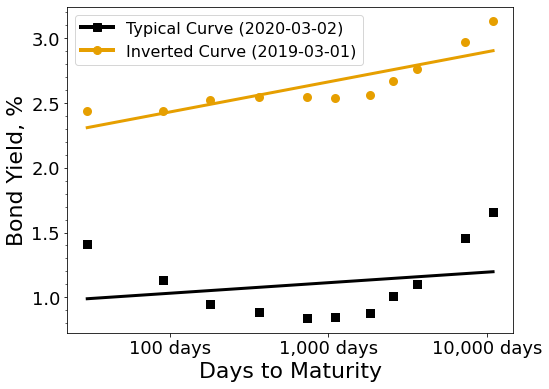

In [15]:
# Load the bonds
bonds = pd.read_csv('data/Bond_Yields.csv')

# Select interested dates
bonds.Date = pd.to_datetime(bonds['Date'])
all_months = ['2019-03-01','2020-03-02']
all_months = pd.to_datetime(all_months)
b = bonds.loc[bonds.Date == all_months[0]]
c = bonds.loc[bonds.Date == all_months[1]]

# Make a plot
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Pop columns with null data 
x_1 = list(b.columns)
x_1.pop(0)
x_1.pop(1)

# Get the associated values
all_tweets_1 = []
all_tweets_2 = []

for i in range(len(x_1)):
    all_tweets_1.append(b[x_1[i]].mean())
    all_tweets_2.append(c[x_1[i]].mean())
    #all_e.append(mean_confidence_interval(b[x_1[i]]))

# Get a list of x    
x = [30,90,180,365,730,1095,1825,2555,3650,7300,10950]
x = [np.log10(y) for y in x]
x_poly = []
for m in range(len(x)-1):
    if m == 0:
        x_a = 0
    else:
        x_a = x[m-1]
    x_b = x[m]
    for n in [.2,.4,.6,.8,1]:
        x_poly.append(x_a + (x_b - x_a) * n)
      
coef = np.polyfit(x,all_tweets_2,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_2, marker='s', color = "black",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='black',lw=3)
        
coef = np.polyfit(x,all_tweets_1,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_1, marker='o', color = "#E69F00",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='#E69F00',lw=3)


axs.set_ylabel("Bond Yield, %", fontsize = 22)
axs.set_xlabel("Days to Maturity", fontsize = 22)
custom_lines = [Line2D([0], [0], color='black',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#E69F00', lw=4, marker='o',ms=8)]
axs.legend(custom_lines,["Typical Curve ("+str(all_months[1])[:10]+')',"Inverted Curve ("+str(all_months[0])[:10]+')'],fontsize = 16)
axs.tick_params(labelsize=18)
axs.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
axs.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axs.xaxis.set_major_locator(mticker.MultipleLocator(1))
axs.set_xticklabels(('','100 days','1,000 days','10,000 days'))


plt.savefig("plots/Treasury-Bond_Yield-Curve-SI.png",dpi=400)
plt.show()

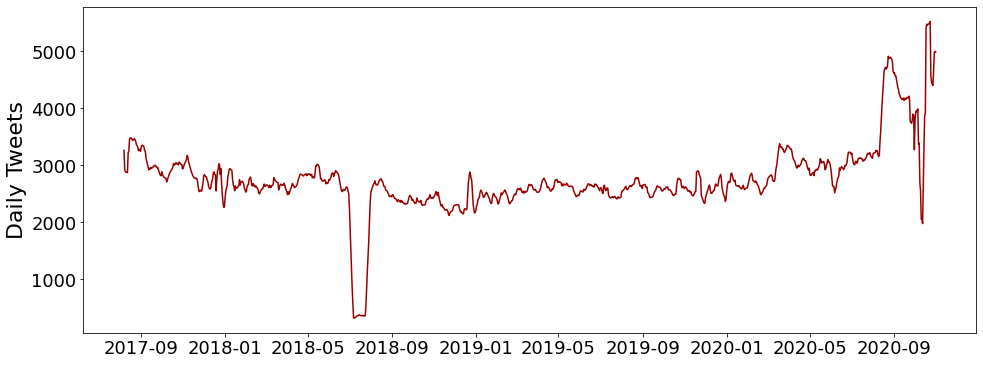

In [18]:


df_counts = df['created_at'].drop_duplicates().groupby(df['created_at'].drop_duplicates().dt.floor('d')).size().reset_index(name='count')

df_2 = df_counts.groupby('created_at', as_index = False)['count'].sum()
df_2 = df_2.loc[df_2.created_at >= '2017-08-01']
fig, axs = plt.subplots(1, 1,figsize=(16,6))
df_2['MA'] = df_2.rolling(window=7).mean()
axs.set_ylabel('Daily Tweets',fontsize=22)
axs.plot(df_2['created_at'],df_2['MA'], color = '#990000')

axs.tick_params(labelsize=18)
plt.savefig("plots/Tweets_over_time_(MA)-SI.png",dpi=400)
plt.show()

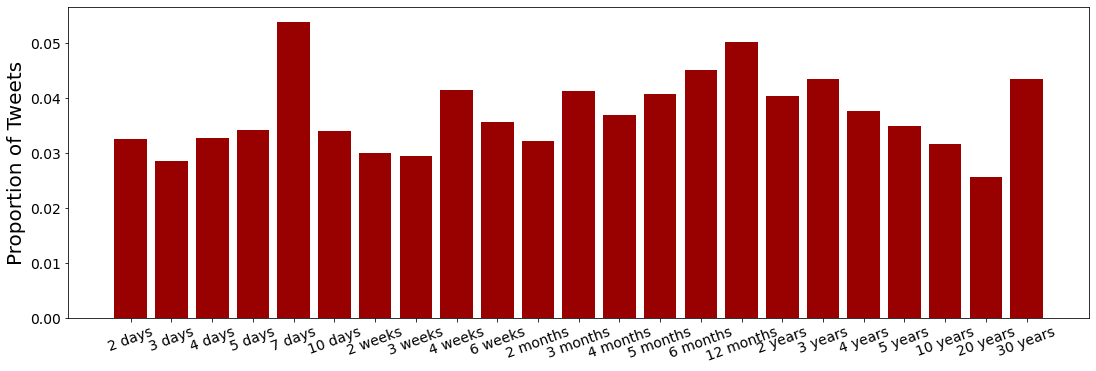

In [28]:
# Read all of the filenames
df = pd.read_csv('data/tweets.csv')
df = df.loc[df.vader!=0]
df.created_at = pd.to_datetime(df['created_at'])
df = df.dropna(subset=['vader'])
df_bots = df.copy()
df = df.loc[~df.ID.isin(list(df_bot_accounts.ID))]

dif_counts = []
dif_counts_props = []
all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']
for p in all_phrases:
    all_tweets = df_bots.loc[df_bots['phrase'] == p].vader.count()
    bots_removed = df.loc[df['phrase'] == p].vader.count()
    
    dif_counts.append(all_tweets - bots_removed)
    dif_counts_props.append((all_tweets - bots_removed) / all_tweets)
    

bars = ('2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years')
y_pos = np.arange(len(bars))

# Create the figure
fig, axs = plt.subplots(1, 1,figsize=(16,6))
fig.tight_layout(pad=5)
axs.bar(y_pos, dif_counts_props,color = "#990000")
axs.set_xticks(y_pos)
axs.set_xticklabels(all_phrases, rotation= 20) 
axs.tick_params(labelsize=14)
axs.set_ylabel('Proportion of Tweets',fontsize=20)

plt.savefig('plots/bot-tweets-per-phrase.png',dpi=400)
plt.show()


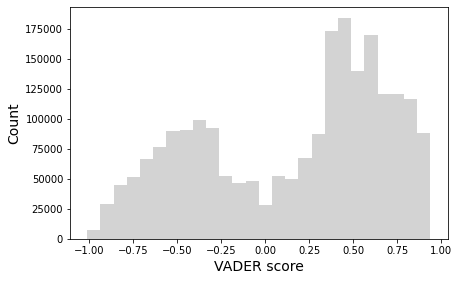

In [30]:
fig, axs = plt.subplots(1, 1,figsize=(6,4))
fig.tight_layout(pad=2.5)
plt.gcf().subplots_adjust(left=.05, top = .95)
    
axs.hist(df.vader, bins=np.arange(-1.0125, 1.0125, 0.075),color = '#d3d3d3')
axs.set_ylabel("Count", fontsize = 14)
axs.set_xlabel("VADER score", fontsize = 14)
plt.savefig('plots/hist-vader.png',dpi=400,bbox_inches='tight')
plt.show()

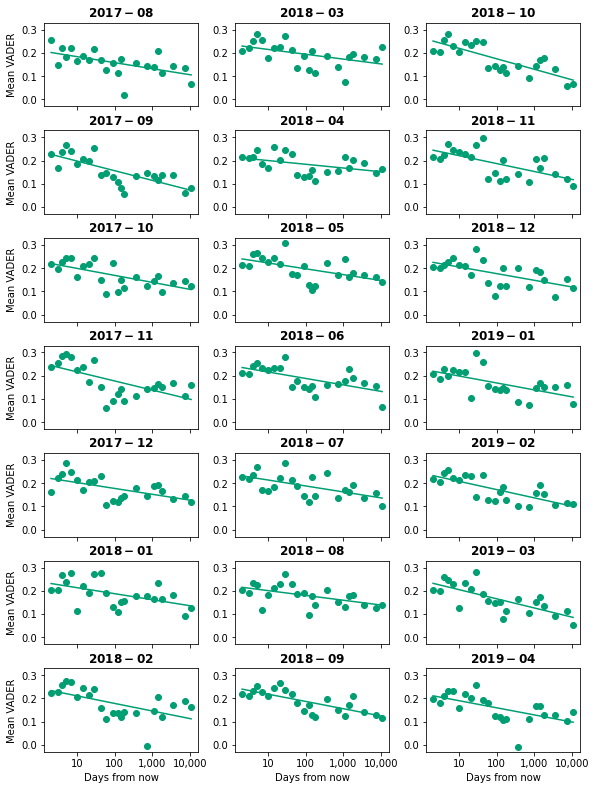

In [38]:


all_months = []
for m in ['08','09','10','11','12']:
    all_months.append('2017-'+m+"-01")
for y in ['2018','2019']:
    for m in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        all_months.append(y+'-'+m+"-01")
for m in ['01','02','03','04']:
    all_months.append('2019-'+m+"-01")

# Get their positions in the figure
fig_row = []
fig_col = []
for j in [0,1,2]:
    for i in [0,1,2,3,4,5,6]:
        fig_col.append(j)
        fig_row.append(i)

# Get some seperate colors
cols = ['#009E73' for i in range(36)]
        
# Create a figure with the appropriate amount of slots
fig, axs = plt.subplots(7, 3,figsize=(8,10.5)) # 9 by 12 before
fig.tight_layout(pad=0.3)

# Get the X axis in log scale
x = [np.log10(n) for n in [2,3,4,5,7,10,14,21,28,42,60,90,120,150,180,365,730,3*365,4*365,5*365,10*365,20*365,30*365]] 

# For all of those months
for i in range(21):
    
    t_1 = all_months[i]
    t_2 = all_months[i+1]
    
    # Get the appropriate month
    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_main = df.loc[mask]
    
    # Find the means
    all_tweets = [df_main.loc[df_main['phrase'] == phrase].vader.mean() for phrase in all_phrases]
    
    # Find the best fit 4th degree polynomial
    coef = np.polyfit(x,all_tweets,1)
    poly1d_fn = np.poly1d(coef) 
    axs[fig_row[i], fig_col[i]].set_xticklabels(('','','','',''))
    if fig_col[i] == 0:
        axs[fig_row[i], fig_col[i]].set_ylabel("Mean VADER")
    if fig_row[i] == 6:
        axs[fig_row[i], fig_col[i]].set_xlabel("Days from now")
        axs[fig_row[i], fig_col[i]].set_xticklabels(('','10','100','1,000','10,000'))

    # Plot this
    axs[fig_row[i], fig_col[i]].plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color=cols[i])
    axs[fig_row[i], fig_col[i]].set_title(r"$\bf{" + all_months[i][:len(all_months[i])-3] + "}$")
    axs[fig_row[i], fig_col[i]].set_ylim([-.03,0.33])
plt.savefig('plots/All_Months-1.png', dpi = 400,bbox_inches='tight')

plt.show()

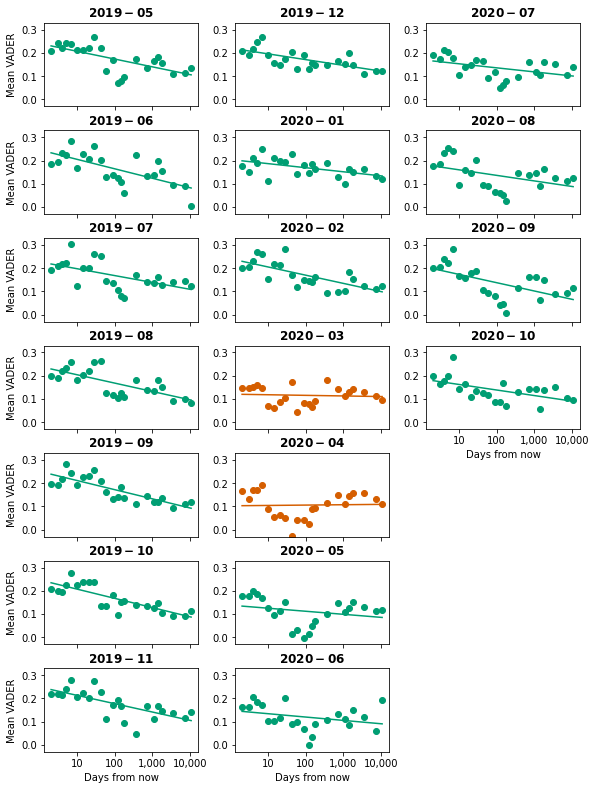

In [39]:
all_months = []
for m in ['05','06','07','08','09','10','11','12']:
    all_months.append('2019-'+m+"-01")
for m in ['01','02','03','04','05','06','07','08','09','10','11']:
    all_months.append('2020-'+m+"-01")

# Get their positions in the figure
fig_row = []
fig_col = []
for j in [0,1,2]:
    for i in [0,1,2,3,4,5,6]:
        fig_col.append(j)
        fig_row.append(i)

# Get some seperate colors
cols = ['#009E73' for i in range(10)]
for i in range(2):
    cols.append('#D55E00') 
for i in range(11):
    cols.append('#009E73') 

# Create a figure with the appropriate amount of slots
fig, axs = plt.subplots(7, 3,figsize=(8,10.5))
fig.tight_layout(pad=0.3)

# For all of those months
for i in range(len(all_months)-1):
    
    t_1 = all_months[i]
    t_2 = all_months[i+1]
    
    
    # Get the appropriate month
    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_main = df.loc[mask]
    
    # Find the means
    all_tweets = [df_main.loc[df_main['phrase'] == phrase].vader.mean() for phrase in all_phrases]
    
    # Find the best fit 4th degree polynomial
    coef = np.polyfit(x,all_tweets,1)
    poly1d_fn = np.poly1d(coef) 
    axs[fig_row[i], fig_col[i]].set_xticklabels(('','','','',''))
    if fig_col[i] == 0:
        axs[fig_row[i], fig_col[i]].set_ylabel("Mean VADER")
    if fig_row[i] == 6:
        axs[fig_row[i], fig_col[i]].set_xlabel("Days from now")
        axs[fig_row[i], fig_col[i]].set_xticklabels(('','10','100','1,000','10,000'))
    if fig_col[i] == 2 and fig_row[i] == 3:
        axs[fig_row[i], fig_col[i]].set_xlabel("Days from now")
        axs[fig_row[i], fig_col[i]].set_xticklabels(('','10','100','1,000','10,000'))
    # Plot this
    axs[fig_row[i], fig_col[i]].plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color=cols[i])
    axs[fig_row[i], fig_col[i]].set_title(r"$\bf{" + all_months[i][:len(all_months[i])-3] + "}$")
    axs[fig_row[i], fig_col[i]].set_ylim([-.03,0.33])
axs[4, 2].axis('off')
axs[5, 2].axis('off')
axs[6, 2].axis('off')
plt.savefig('plots/All_Months-2.png', dpi = 400,bbox_inches='tight')

plt.show()

 
-0.0312 x + 0.2367
 
-0.01705 x + 0.1566


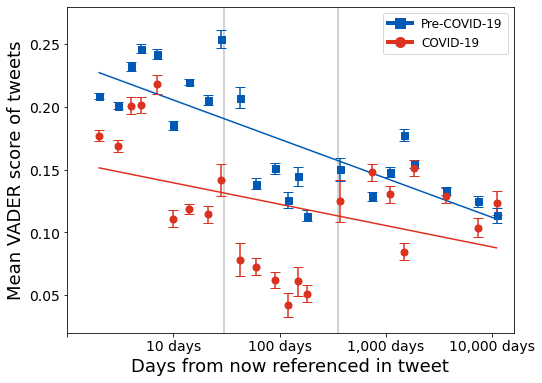

In [43]:
# responding comment

# Plot March 2019 and 2020
fig, axs = plt.subplots(1, 1,figsize=(8,6))


axs.plot([np.log10(30), np.log10(30)], [0, .3], '-', color = '#d3d3d3', lw=2)
axs.plot([np.log10(350), np.log10(350)], [0, .3], '-', color = '#d3d3d3', lw=2)

# Plot 2019
mask = (pd.Timestamp('2017-08-01'+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp("2020-03-11"+' 00:00:00+0000'))
df_main = df.loc[mask]

# Helper function for confidence intervals
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2, n-1)
    return h

all_tweets = [df_main.loc[df_main['phrase'] == phrase]['vader'].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase]['vader']) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='s', ecolor="#005AB5", mec="#005AB5", mfc="#005AB5", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#005AB5")


# Plot 2020
mask = (pd.Timestamp('2020-03-11'+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp("2020-10-31"+' 00:00:00+0000'))
df_main = df.loc[mask]
all_tweets = [df_main.loc[df_main['phrase'] == phrase]['vader'].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase]['vader']) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#DC3220", mec="#DC3220", mfc="#DC3220", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#DC3220")

#axs.axvspan(0, np.log10(30), facecolor='#56B4E9', alpha=0.2)
#axs.axvspan(np.log10(30), np.log10(350), facecolor='#009E73', alpha=0.2)
#axs.axvspan(np.log10(350), 4.2, facecolor='#F0E442', alpha=0.2)
axs.set_xlim(0,4.2)
axs.set_ylim(0.02,.28)

# Labels
plt.ylabel('Mean VADER score of tweets', fontsize = 18)
plt.xlabel("Days from now referenced in tweet", fontsize = 18)
custom_lines = [Line2D([0], [0], marker='s', color='#005AB5',  lw=4,markersize=10),
                Line2D([0], [0], marker='o', color='#DC3220', lw=4, markersize=10)]
axs.legend(custom_lines,["Pre-COVID-19","COVID-19"],fontsize = 12)
plt.xticks(np.arange(5), ('','10 days', '100 days','1,000 days','10,000 days'))
axs.tick_params(labelsize=14)

plt.savefig('plots/Sentiment-Yield-Curve-Typical-Inverted-all.png',dpi=400)
plt.show()

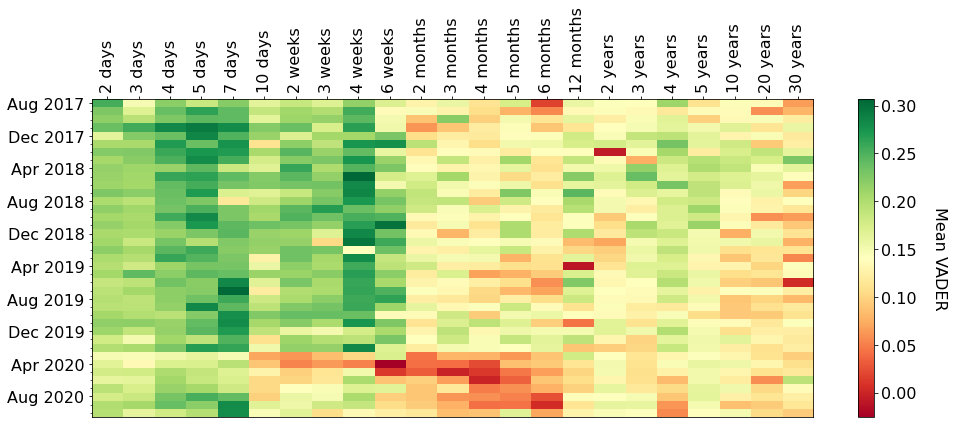

In [49]:
df_heat_map = pd.DataFrame({"date":[]})
for p in all_phrases:
    df_heat_map[p] = []
# For all of those months
all_months = []
for m in ['08','09','10','11','12']:
    all_months.append('2017-'+m+"-01")
for y in ['2018','2019']:
    for m in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        all_months.append(y+'-'+m+"-01")
for m in ['01','02','03','04','05','06','07','08','09','10','11']:
    all_months.append('2020-'+m+"-01")

for i in range(len(all_months)-1):
    t_1 = all_months[i]
    t_2 = all_months[i+1]
    
    # Get the appropriate month
    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_main = df.loc[mask]
    
    means = [df_main.loc[df_main.phrase == p].vader.mean() for p in all_phrases]
    df_heat_map.loc[i] = [all_months[i]] + means
    
def heatmap2d(arr: np.ndarray):
    fig, axs = plt.subplots(1, 1,figsize=(8,8))
    im = axs.imshow(arr, cmap='RdYlGn',interpolation='nearest', aspect='auto')
    c = fig.colorbar(im)
    c.ax.set_ylabel('Mean VADER', rotation=270,fontsize=16)
    c.ax.get_yaxis().labelpad = 15
    axs.set_xticklabels(('',all_phrases[0],all_phrases[5],all_phrases[10],all_phrases[15],all_phrases[20]),rotation=90)
    axs.set_yticklabels(('',all_months[0],all_months[5],all_months[10],all_months[15],all_months[20],all_months[25],all_months[30],all_months[35]))
    axs.tick_params(labelsize=14)
    axs.xaxis.tick_top()
    #plt.savefig("SI-plots/heat_map.png",dpi=400, bbox_inches='tight')
    plt.show()

data = df_heat_map
data = data.set_index('date')
date_range = pd.date_range("2017-08-01", "2020-11-01", freq="MS").strftime("%b %Y").to_list()
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
im = ax.imshow(data, cmap='RdYlGn',interpolation='nearest', aspect='auto')
c = fig.colorbar(im)
c.ax.tick_params(labelsize=16)
c.ax.set_ylabel('Mean VADER', rotation=270, fontsize=16, labelpad=30)
ax.xaxis.set_major_locator(mticker.FixedLocator(range(0, len(all_phrases))))
ax.set_xticklabels(all_phrases, fontsize=16, rotation=90)
ax.xaxis.tick_top()
ax.yaxis.set_major_locator(mticker.FixedLocator(range(0, len(date_range), 4)))
ax.yaxis.set_minor_locator(mticker.MultipleLocator())
ax.set_yticklabels(date_range[::4], fontsize=16)
plt.tight_layout()
plt.savefig("plots/heat_map.png",dpi=400)
plt.show()

# SI tables

Before March 2020 n = 1624426
(-0.7449767863968356, 4.5426133053754316e-05)
0.5549904122701564
The 1 polynomial.


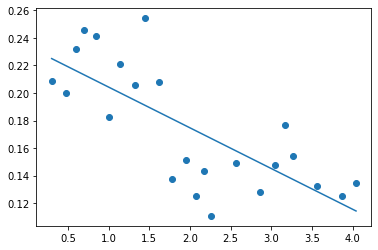

Parameters:  [ 0.23392004 -0.0296114 ]
R2:  0.5549904122701566
The 2 polynomial.


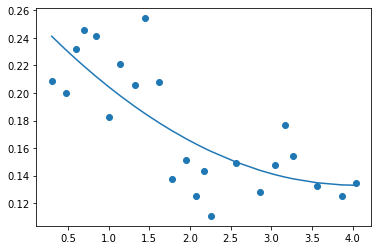

Parameters:  [ 0.2593404  -0.06251926  0.00773466]
R2:  0.594416729250637
The 3 polynomial.


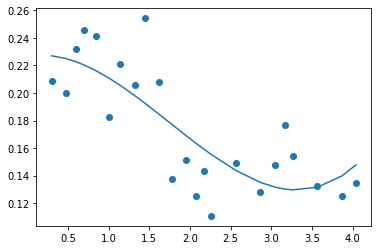

Parameters:  [ 0.22634685  0.01179583 -0.03355183  0.00639131]
R2:  0.620374029485032
The 4 polynomial.


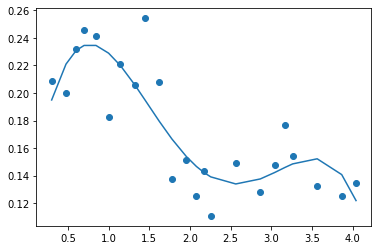

Parameters:  [ 0.10823759  0.39339994 -0.38758853  0.12899715 -0.01409829]
R2:  0.7410788691433254
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0      21.0  0.019782      0.0       NaN       NaN       NaN
1      20.0  0.018029      1.0  0.001753  2.740888  0.113418
2      19.0  0.016875      1.0  0.001154  1.804532  0.194992
3      18.0  0.011510      1.0  0.005366  8.391309  0.009612


/Users/calvinisch/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [68]:
df_main = df.loc[df.created_at < '2020-03-01']
df_main = df_main.loc[df_main.vader != 0]
print('Before March 2020 n =',df_main.vader.count())

all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']

all_tweets = [df_main.loc[df_main['phrase'] == phrase]["vader"].mean() for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef)
r = stats.pearsonr(x,all_tweets)
print(r)
print(r[0]**2)

models = []
for j in range(4):
    print('The',str(j+1),'polynomial.')
    polynomial_features= PolynomialFeatures(degree=j+1)
    xp = polynomial_features.fit_transform([[a] for a in x])
    model = sm.OLS([[a] for a in all_tweets], xp).fit()
    ypred = model.predict(xp)
    plt.scatter([[a] for a in x],[[a] for a in all_tweets])
    plt.plot([[a] for a in x],ypred)
    plt.show()
    
    models.append(model)
    
    print("Parameters: ", model.params)
    print("R2: ", model.rsquared)

anovaResults = anova_lm(models[0], models[1],models[2],models[3])
print(anovaResults)

In [56]:
m_vader, counts, phrases, month = [], [], [], []

# Load the data file for every phrase & get only tweets with some vader
for phrase in all_phrases:
    df_temp = df.loc[df.phrase == phrase]

    for m in range(len(all_months)-1):
        
        # Look at each month individually 
        mask = (pd.Timestamp(all_months[m]+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(all_months[m+1]+' 00:00:00+0000'))
        df_main = df_temp.loc[mask]
        
        # Store mean vader, fear, concreteness, count, and phrase
        m_vader.append(df_main.vader.mean())
        counts.append(df_main.vader.count())
        phrases.append(phrase)
        month.append(all_months[m])

df_months = pd.DataFrame({'month_VADER':m_vader,'count':counts,'phrase':phrases,'month':month})


# SI table descriptives
df_temp = df_months.loc[df_months.month < '2020-03-01']
df_temp = df_temp.loc[df_temp.month >= '2017-08-01']
print('Skew',stats.skew(df_temp['month_VADER']))
print('Kurtosis',stats.kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2 days') | (df_temp.phrase == '3 days') | (df_temp.phrase == '4 days') | (df_temp.phrase == '5 days') | (df_temp.phrase == '7 days') | (df_temp.phrase == '10 days') | (df_temp.phrase == '2 Weeks') | (df_temp.phrase == '3 weeks') | (df_temp.phrase == '4 weeks')]
med = df_temp.loc[(df_temp.phrase == '6 weeks') | (df_temp.phrase == '2 months') | (df_temp.phrase == '3 months') | (df_temp.phrase == '4 months') | (df_temp.phrase == '5 months') | (df_temp.phrase == '6 months')]
far = df_temp.loc[(df_temp.phrase == '12 months') | (df_temp.phrase == '2 years') | (df_temp.phrase == '3 years') | (df_temp.phrase == '4 years') | (df_temp.phrase == '5 years') | (df_temp.phrase == '10 years') | (df_temp.phrase == '20 years') | (df_temp.phrase == '30 years')]
print("Near:",near.month_VADER.mean(),near.month_VADER.std())
print('Skew',stats.skew(near['month_VADER']))
print('Kurtosis',stats.kurtosis(near['month_VADER']), "Count",near.month_VADER.count())
print("jb",stats.jarque_bera(near['month_VADER']))

print("Med:",med.month_VADER.mean(),med.month_VADER.std())
print('Skew',stats.skew(med['month_VADER']))
print('Kurtosis',stats.kurtosis(med['month_VADER']), "Count",med.month_VADER.count())
print("jb",stats.jarque_bera(med['month_VADER']))

print("far:",far.month_VADER.mean(),far.month_VADER.std())
print('Skew',stats.skew(far['month_VADER']))
print('Kurtosis',stats.kurtosis(far['month_VADER']), "Count",far.month_VADER.count())
print("jb",stats.jarque_bera(far['month_VADER']))

print("\n\nPandemic")
df_temp = df_months.loc[df_months.month >= '2020-03-01']
print('Skew',stats.skew(df_temp['month_VADER']))
print('Kurtosis',stats.kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2 days') | (df_temp.phrase == '3 days') | (df_temp.phrase == '4 days') | (df_temp.phrase == '5 days') | (df_temp.phrase == '7 days') | (df_temp.phrase == '10 days') | (df_temp.phrase == '2 Weeks') | (df_temp.phrase == '3 weeks') | (df_temp.phrase == '4 weeks')]
med = df_temp.loc[(df_temp.phrase == '6 weeks') | (df_temp.phrase == '2 months') | (df_temp.phrase == '3 months') | (df_temp.phrase == '4 months') | (df_temp.phrase == '5 months') | (df_temp.phrase == '6 months')]
far = df_temp.loc[(df_temp.phrase == '12 months') | (df_temp.phrase == '2 years') | (df_temp.phrase == '3 years') | (df_temp.phrase == '4 years') | (df_temp.phrase == '5 years') | (df_temp.phrase == '10 years') | (df_temp.phrase == '20 years') | (df_temp.phrase == '30 years')]
print("Near:",near.month_VADER.mean(),near.month_VADER.std())
print('Skew',stats.skew(near['month_VADER']))
print('Kurtosis',stats.kurtosis(near['month_VADER']), "Count",near.month_VADER.count())
print("jb",stats.jarque_bera(near['month_VADER']))

print("Med:",med.month_VADER.mean(),med.month_VADER.std())
print('Skew',stats.skew(med['month_VADER']))
print('Kurtosis',stats.kurtosis(med['month_VADER']), "Count",med.month_VADER.count())
print("jb",stats.jarque_bera(med['month_VADER']))

print("far:",far.month_VADER.mean(),far.month_VADER.std())
print('Skew',stats.skew(far['month_VADER']))
print('Kurtosis',stats.kurtosis(far['month_VADER']), "Count",far.month_VADER.count())
print("jb",stats.jarque_bera(far['month_VADER']))


Skew -0.04985707259864343
Kurtosis -0.38651877864228235 Count 713
Near: 0.22240164269945628 0.03685001924391601
Skew -0.3980801313178127
Kurtosis 0.5373164192134827 Count 248
jb Jarque_beraResult(statistic=9.533327680949746, pvalue=0.008508719306673296)
Med: 0.14807628860281832 0.04478782970427439
Skew 0.5597642342436857
Kurtosis 0.6553611963706181 Count 186
jb Jarque_beraResult(statistic=13.04202774333054, pvalue=0.0014721757481698239)
far: 0.14240923092299654 0.0400735818871514
Skew -0.47467327969968
Kurtosis 1.35693367391801 Count 248
jb Jarque_beraResult(statistic=28.33945481431232, pvalue=7.017227828809425e-07)


Pandemic
Skew -0.01020858931543035
Kurtosis 0.04593246194261713 Count 184
Near: 0.16688358425541877 0.04812782514085641
Skew -0.12393672793958109
Kurtosis 0.13721002594823517 Count 64
jb Jarque_beraResult(statistic=0.2140475769338515, pvalue=0.8985042986962835)
Med: 0.06907913007611026 0.04255888221119775
Skew 0.27428419571388657
Kurtosis 0.27137207560686694 Count 48
jb J